In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import auc, roc_curve

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\94333\Python\env_ds_39\Scripts\python.exe -m pip install --upgrade pip' command.


# 1. Loading Datasets

In [3]:
data = pd.read_csv('../data/data.csv')

# 2. EDA and Visualization

In [4]:
data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

<AxesSubplot:>

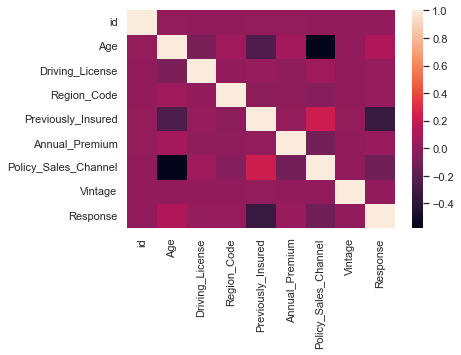

In [5]:
corr=data.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In [6]:
respon1 = data[data['Response']==1]
respon0 = data[data['Response']==0]

<AxesSubplot:>

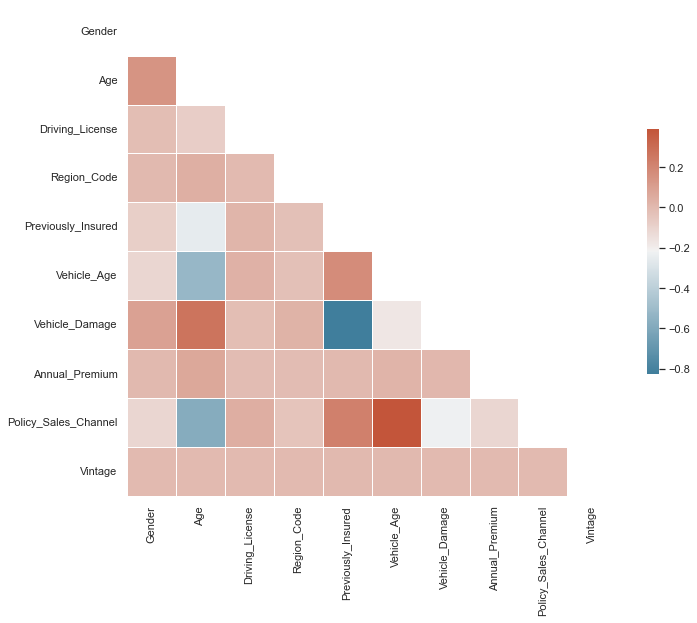

In [7]:
col_list = data.columns.to_list()[1:]
df_train_corr = data.copy().set_index('id')
df_train_ones = df_train_corr.loc[df_train_corr.Response == 1].copy()

categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
text_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# code text categorical features
le = preprocessing.LabelEncoder()
for f in text_features :
    df_train_corr[f] = le.fit_transform(df_train_corr[f])
# change digital categorical datatype so CatBoost can deal with them
df_train_corr.Region_Code = df_train_corr.Region_Code.astype('int32')
df_train_corr.Policy_Sales_Channel = df_train_corr.Policy_Sales_Channel.astype('int32')

corr = df_train_corr.loc[:,:'Vintage'].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

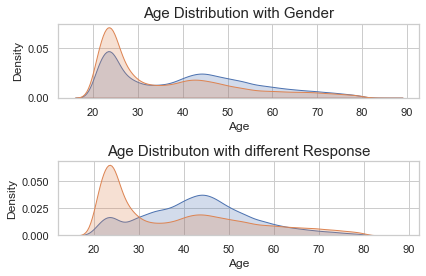

In [8]:
#age
plt.subplot(211)
plt.title('Age Distribution with Gender',fontsize=15)
men = data[data['Gender']=='Male']
women = data[data['Gender']=='Female']
a = sns.kdeplot(men['Age'], shade='True', legend='True', label='Male')
b = sns.kdeplot(women['Age'], shade='True', legend='True', label='Female')

plt.subplot(212)
plt.title('Age Distributon with different Response',fontsize=15)
a = sns.kdeplot(respon1['Age'], shade='True', legend='True', label='Respon1')
b = sns.kdeplot(respon0['Age'], shade='True', legend='True', label='Respon0')

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

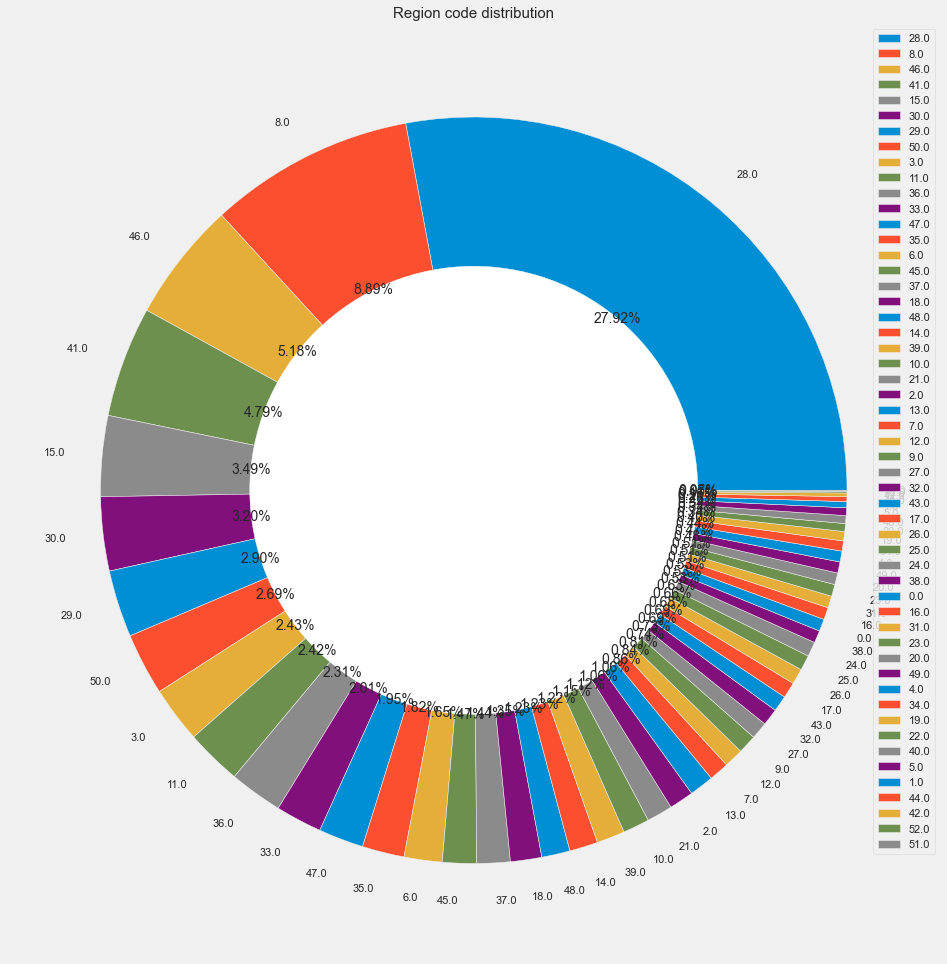

In [9]:
#Region code
sns.set(style="darkgrid")
plt.style.use('fivethirtyeight')


plt.title('Region code distribution',fontsize=15)
circle = plt.Circle((0, 0), 0.6, color = 'white')
data['Region_Code'].value_counts().plot(kind='pie', figsize=(16, 16), rot=1,autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

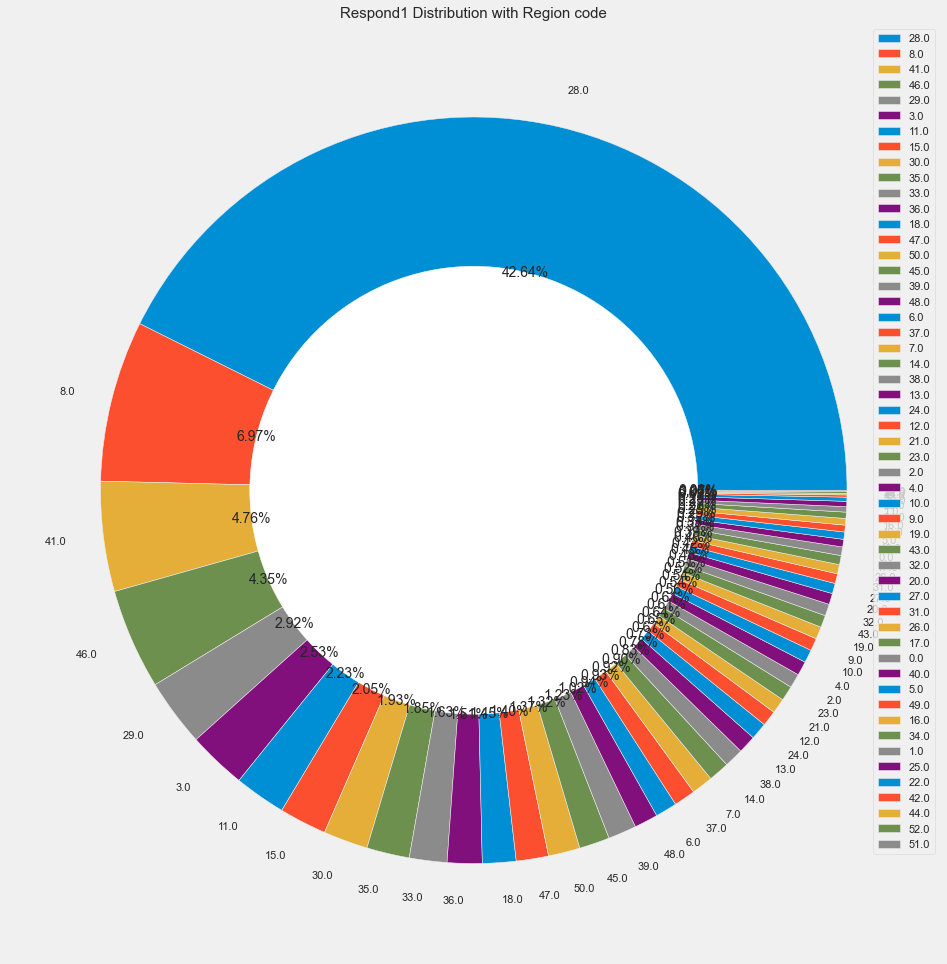

In [10]:
plt.title('Respond1 Distribution with Region code',fontsize=15)
circle = plt.Circle((0, 0), 0.6, color = 'white')
respon1['Region_Code'].value_counts().plot(kind='pie', figsize=(16, 16), rot=1,autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

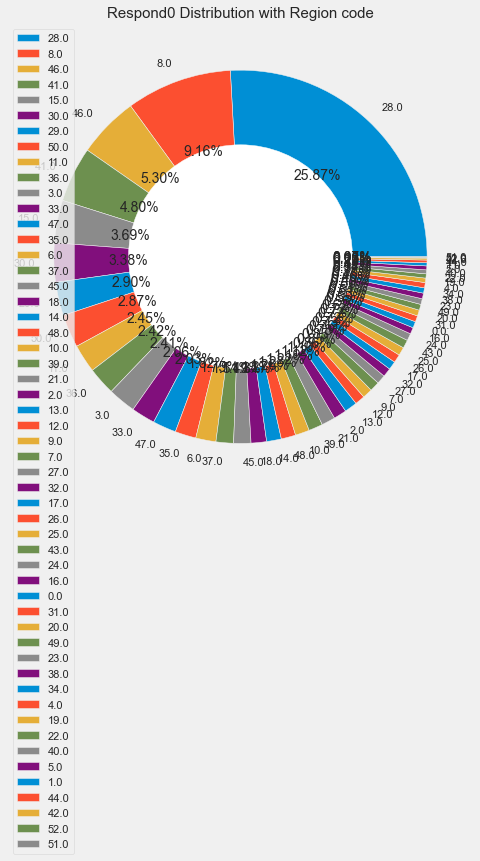

In [11]:
plt.title('Respond0 Distribution with Region code',fontsize=15)
circle = plt.Circle((0, 0), 0.6, color = 'white')
respon0['Region_Code'].value_counts().plot(kind='pie', figsize=(8, 8), rot=1,autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()

plt.show

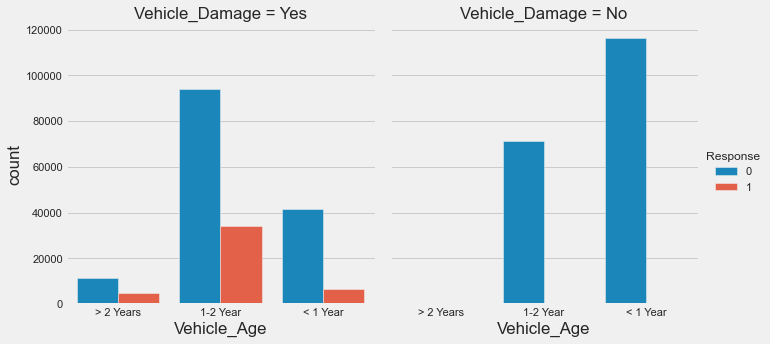

In [12]:
#Vehicle_Age
#Vehicle_Damage

ax = sns.catplot(data=data, x='Vehicle_Age', hue='Response', col='Vehicle_Damage', kind='count')

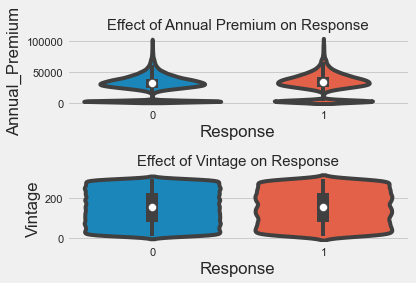

In [13]:
#Annual_Premium
#Vintage
plt.subplot(211)
plt.title('Effect of Annual Premium on Response',fontsize=15)
ax = sns.violinplot(data=data[data['Annual_Premium']<100000], y="Annual_Premium", x="Response")
plt.subplot(212)
plt.title('Effect of Vintage on Response',fontsize=15)
bx = sns.violinplot(data=data, y="Vintage", x="Response")
plt.tight_layout()
plt.show()

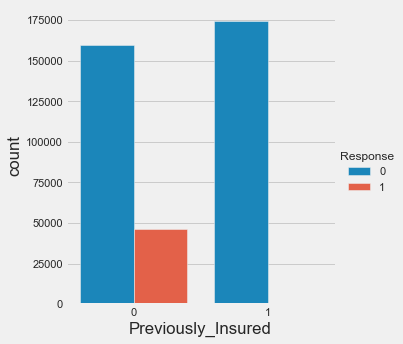

In [14]:
#Previously_Insured
sns.catplot(data=data, x='Previously_Insured', hue='Response', kind='count')

<AxesSubplot:xlabel='Channel', ylabel='Percentage'>

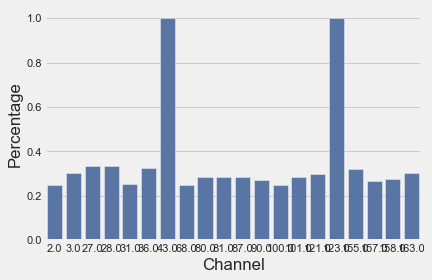

In [15]:
#Policy_Sales_Channel
channellist=[]
for x in data.Policy_Sales_Channel.values:
    if x not in channellist:
        channellist.append(x)

channel_per=[]
for k in channellist:
    a=respon1[respon1['Policy_Sales_Channel']==k].id.count()
    b=data[data['Policy_Sales_Channel']==k].id.count()
    per=a/b
    channel_per.append(per)
    
dict={'Channel':channellist,'Percentage':channel_per}    
policychannel_percentage=pd.DataFrame(dict)
crank=policychannel_percentage.sort_values(["Percentage"],ascending=False).head(20)
sns.barplot(x="Channel", y="Percentage", data=crank,
            label="Total", color="b")

# 3. Models Test & Selection

In [16]:
gender_one_hot = pd.get_dummies(data['Gender'])
vehicle_age_one_hot = pd.get_dummies(data['Vehicle_Age'], prefix='Vehicle_Age')
vehicle_damage_one_hot = pd.get_dummies(data['Vehicle_Damage'], prefix='Vehicle_Damage')
preprocessed_data = pd.concat([data, gender_one_hot, vehicle_age_one_hot, vehicle_damage_one_hot], axis=1)
preprocessed_data = preprocessed_data.drop(['id', 'Gender', 'Vehicle_Age', 'Vehicle_Damage'], axis=1)

In [29]:
preprocessed_data

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Female,Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,1,0,1,0,0,1,0,1
1,76,1,3.0,0,33536.0,26.0,183,0,0,1,1,0,0,1,0
2,47,1,28.0,0,38294.0,26.0,27,1,0,1,0,0,1,0,1
3,21,1,11.0,1,28619.0,152.0,203,0,0,1,0,1,0,1,0
4,29,1,41.0,1,27496.0,152.0,39,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,74,1,26.0,1,30170.0,26.0,88,0,0,1,1,0,0,1,0
381105,30,1,37.0,1,40016.0,152.0,131,0,0,1,0,1,0,1,0
381106,21,1,30.0,1,35118.0,160.0,161,0,0,1,0,1,0,1,0
381107,68,1,14.0,0,44617.0,124.0,74,0,1,0,0,0,1,0,1


In [17]:
x = preprocessed_data.drop('Response', axis=1)
y = data['Response']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf = DecisionTreeClassifier().fit(x_train, y_train)

In [18]:
accuracy = clf.score(x_test,y_test)
accuracy

0.822964498438771

In [19]:
y_dt = clf.predict_proba(x_test)

AUC of Decision Tree: 0.6000747922660018


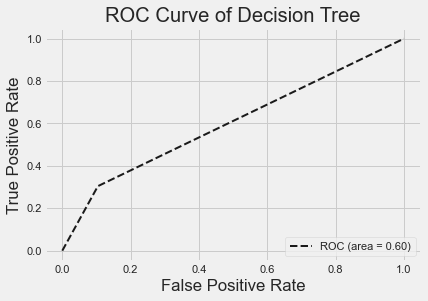

In [20]:
fpr_dt, tpr_dt, thersholds_dt = roc_curve(y_test, y_dt[:,1], pos_label = 1)

# for i, value in enumerate(thersholds_rf):
#     print("%f %f %f" % (fpr_rf[i], tpr_rf[i], value))
    
roc_auc_dt = auc(fpr_dt, tpr_dt)
print("AUC of Decision Tree:", roc_auc_dt)
plt.plot(fpr_dt, tpr_dt, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc_dt), lw=2)
 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.legend(loc="lower right")
plt.show()

# print('FPR = ', fpr_rf)
# print('TPR = ', tpr_rf)
# print('Thresholds = ', thersholds_rf)

In [21]:
rf_clf = RandomForestClassifier().fit(x_train, y_train)
accuracy_rf = rf_clf.score(x_test,y_test)
accuracy_rf

0.8661147700139068

In [22]:
y_rf = rf_clf.predict_proba(x_test)
print(y_rf[y_rf == 1])
print(len(y_rf == 1))

[1. 1. 1. ... 1. 1. 1.]
76222


AUC of Random Forest: 0.83516387505643


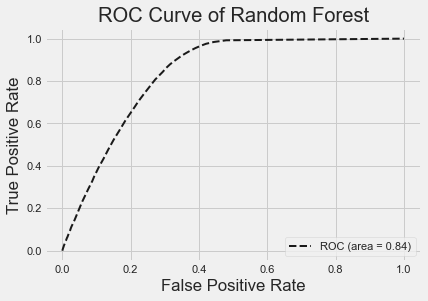

In [23]:
fpr_rf, tpr_rf, thersholds_rf = roc_curve(y_test, y_rf[:,1], pos_label = 1)

# for i, value in enumerate(thersholds_rf):
#     print("%f %f %f" % (fpr_rf[i], tpr_rf[i], value))
    
roc_auc_rf = auc(fpr_rf, tpr_rf)
print("AUC of Random Forest:", roc_auc_rf)
plt.plot(fpr_rf, tpr_rf, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc_rf), lw=2)
 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.legend(loc="lower right")
plt.show()

# print('FPR = ', fpr_rf)
# print('TPR = ', tpr_rf)
# print('Thresholds = ', thersholds_rf)

In [24]:
boost_clf = GradientBoostingClassifier().fit(x_train, y_train)
accuracy_boost = boost_clf.score(x_test,y_test)
accuracy_boost
y_gb = boost_clf.predict_proba(x_test)
print(y_gb[y_gb == 1])


[]


In [25]:
print(y_gb)

[[0.9724407  0.0275593 ]
 [0.99098647 0.00901353]
 [0.76204728 0.23795272]
 ...
 [0.99832962 0.00167038]
 [0.99889597 0.00110403]
 [0.9982047  0.0017953 ]]


AUC of Gradient Boosting: 0.8569563122016994


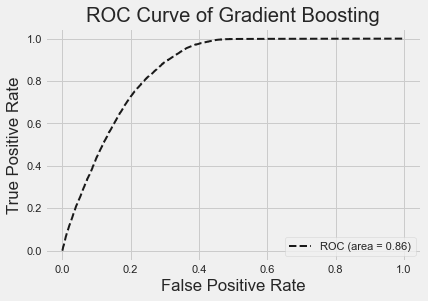

In [26]:
fpr_gb, tpr_gb, thersholds_gb = roc_curve(y_test, y_gb[:,1], pos_label = 1)

# for i, value in enumerate(thersholds_gb):
#     print("%f %f %f" % (fpr_gb[i], tpr_gb[i], value))
    
roc_auc_gb = auc(fpr_gb, tpr_gb)
print("AUC of Gradient Boosting:", roc_auc_gb)
plt.plot(fpr_gb, tpr_gb, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc_gb), lw=2)
 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

# print('FPR = ', fpr_gb)
# print('TPR = ', tpr_gb)
# print('Thresholds = ', thersholds_gb)

In [27]:
lr_model = LogisticRegression(penalty='l2').fit(x_train, y_train)
y_lr = lr_model.predict_proba(x_test)

C:\Users\94333\Python\env_ds_39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC of Logistic Regression: 0.7221457446181496


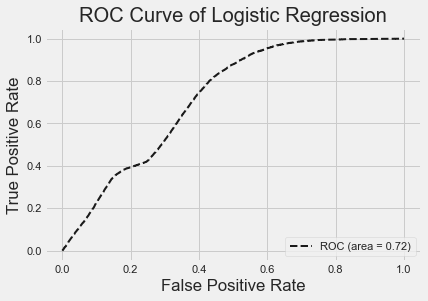

In [28]:
fpr_lr, tpr_lr, thersholds_lr = roc_curve(y_test, y_lr[:,1], pos_label = 1)

# for i, value in enumerate(thersholds_lr):
#     print("%f %f %f" % (fpr_lr[i], tpr_lr[i], value))
    
roc_auc_lr = auc(fpr_lr, tpr_lr)
print("AUC of Logistic Regression:", roc_auc_lr)
plt.plot(fpr_lr, tpr_lr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc_lr), lw=2)
 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# print('FPR = ', fpr_lr)
# print('TPR = ', tpr_lr)
# print('Thresholds = ', thersholds_lr)